In [1]:
%load_ext lab_black

from ctypes import CDLL, Structure, c_int, c_uint16, c_uint32, c_bool, POINTER
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import ctypes
import matplotlib.pyplot as plt
import numpy as np
import os
import serial
import time

Se carga el archivo de audio

In [2]:
base_path = "/tf/notebooks/CEIA/ia-embebida/noise-gate"
assets_path = os.path.join(base_path, "assets")
audios_path = os.path.join(assets_path, "audios")
labels_path = os.path.join(assets_path, "labels")

samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))

data_len = len(data)
duration = data_len / samplerate
print(f"Cantidad de muestras: {data_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")
print(f"Valor maximo: {max(data)}")
print(f"Valor minimo: {min(data)}")
print(f"Tipo de dato: {type(data[0])}")

Cantidad de muestras: 956007
Frecuencia de muestreo: 22050 Hz
Duracion: 43.4 segundos
Valor maximo: 32767
Valor minimo: -32768
Tipo de dato: <class 'numpy.int16'>


/tmp/ipykernel_11/2236063515.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))


Graficamos la señal y su fft

In [236]:
timeline = np.linspace(0, duration, num=data_len)

x_freq = fftfreq(data_len, 1 / samplerate)[: data_len // 2]
data_fft = np.abs(fft(data)[0 : data_len // 2])

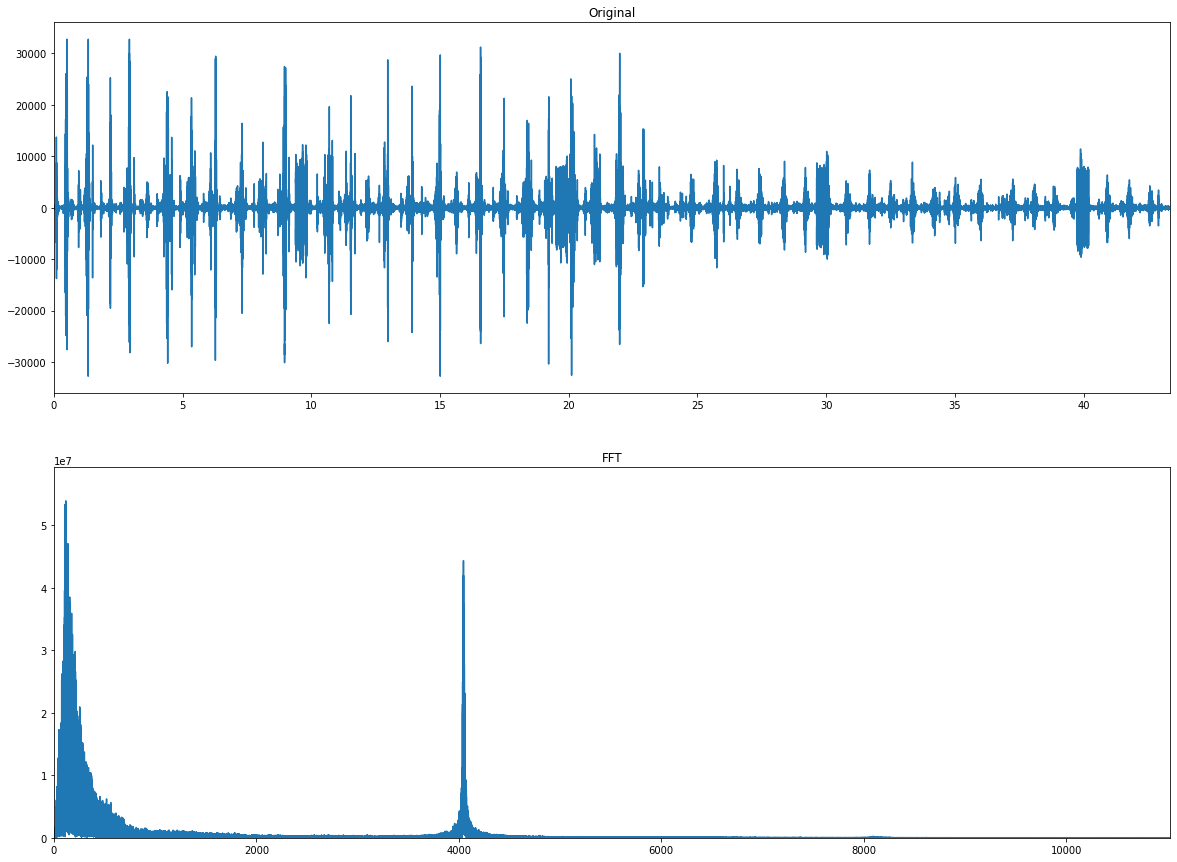

In [237]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(timeline, data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(x_freq, data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("FFT")

f.show()

Diseñamos un filtro pasa bajo con una banda de paso de hasta 2000Hz y lo aplicamos a nuestra señal

In [238]:
filter_order, wn = signal.buttord(
    wp=2000, ws=3000, gpass=3, gstop=40, analog=False, fs=samplerate
)
b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=samplerate)

In [239]:
filtered_data = signal.lfilter(b, a, data)
filtered_data_fft = np.abs(fft(filtered_data)[0 : data_len // 2])

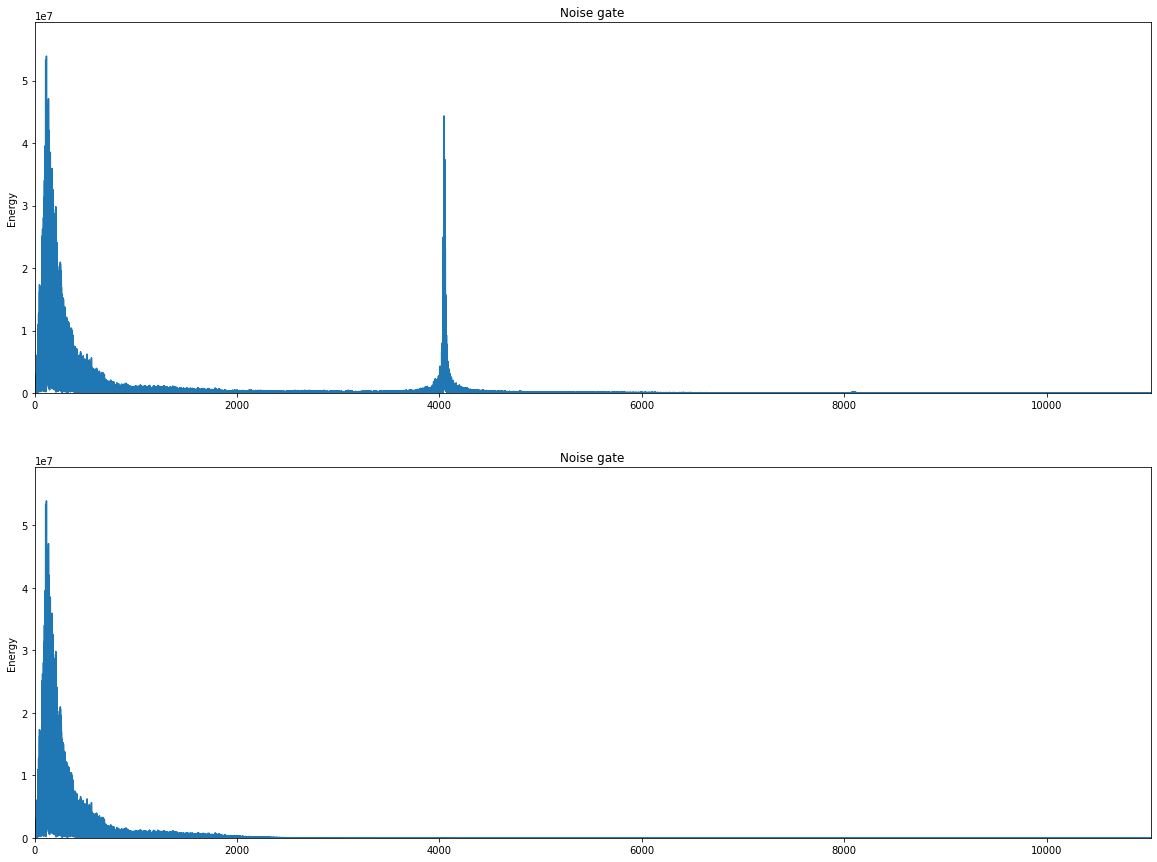

In [240]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(x_freq, data_fft)
axes[0].set_xlim([0, x_freq[-1]])
axes[0].set_ylim([0, max(data_fft) * 1.1])
axes[0].set_title("Noise gate")
axes[0].set_ylabel("Energy")

axes[1].plot(x_freq, filtered_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Hacemos la decimación y reducimos la frecuencia de muestreo 10 veces, es decir a 2.2KHz

In [241]:
dec_data = filtered_data[::10]
dec_timeline = timeline[::10]

dec_samplerate = samplerate / 10
dec_data_len = len(dec_data)
dec_data_fft = np.abs(fft(dec_data)[0 : dec_data_len // 2])
dec_x_freq = fftfreq(dec_data_len, 1 / dec_samplerate)[: dec_data_len // 2]

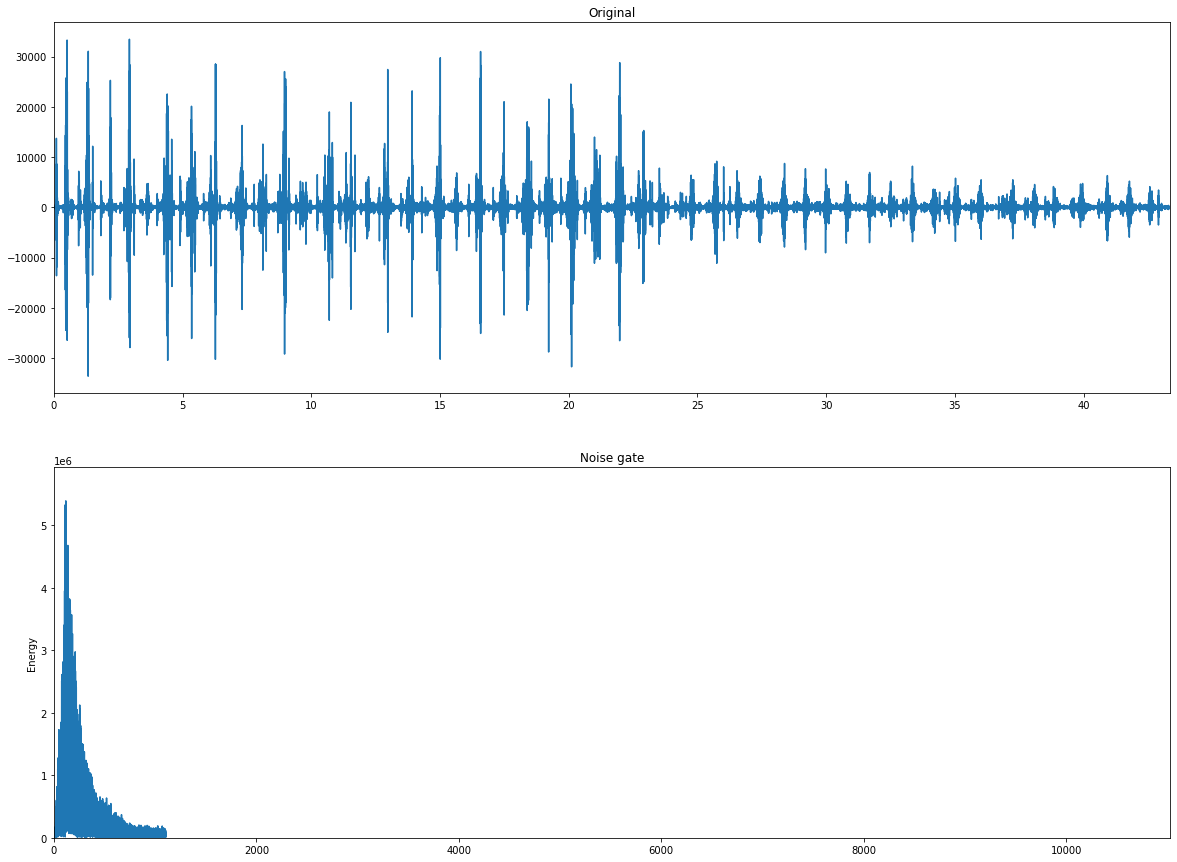

In [242]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, dec_data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(dec_x_freq, dec_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(dec_data_fft) * 1.1])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

Elevamos los valores al cuadrado y aplicamos el filtro de promedio móvil

In [307]:
# filter_order, wn = signal.buttord(
#     wp=200, ws=300, gpass=3, gstop=40, analog=False, fs=dec_samplerate
# )
# b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=samplerate)

filter_order, wn = signal.cheb1ord(
    wp=50, ws=100, gpass=3, gstop=40, analog=False, fs=dec_samplerate
)
b, a = signal.cheby1(filter_order, 3, wn, "lowpass", analog=False, fs=samplerate)

In [308]:
filtered_data_2 = signal.lfilter(b, a, dec_data)
filtered_data_fft_2 = np.abs(fft(filtered_data_2)[0 : dec_data_len // 2])

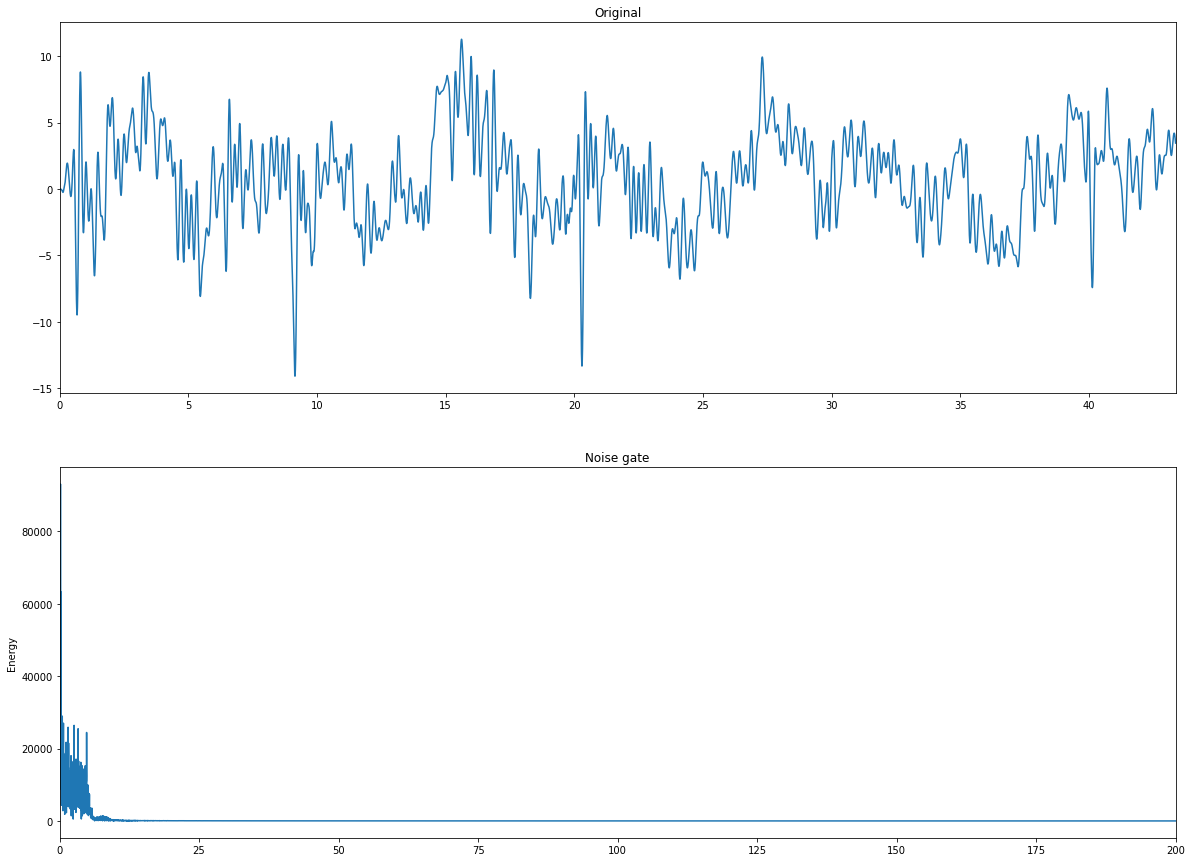

In [310]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, filtered_data_2)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(dec_x_freq, filtered_data_fft_2)
axes[1].set_xlim([0, 200])
# axes[1].set_ylim([0, 2.5e7])
# axes[1].set_ylim([0, max(ma_data_fft)])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

f.show()

No entiendo porque el filtro empieza a filtrar a partir de los 10Hz y no a partir de los 50 como se definió en las especificaciones del filtro